# Kaggle Titanic survival - Receiever Operator Characteristic (ROC) curve

Frequently in machine learning we wish to go beyond measuring raw accuracy. This is especially true when classes are unbalanced, where errors are often greater in one class than the other. The Receiver Operator Characteristic (ROC) curve allows us to better understand the trade-off between sensitivity (the ability to detect positives of a certain class) and specificity (the ability to detect negatives of a certain class). The area under the ROC curve is also often used to compare different models: a higher Area Under Curve (AUC) is frequently the sign of a better model.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity or recall. The false-positive rate can be calculated as (1 − specificity).

In this notebook we repeat our basic logistic regression model as previously described:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/02_logistic_regression.ipynb

We will extend the model to report a range of accuracy measures, as described:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/05_accuracy_standalone.ipynbnd

We use false positive rate and true positive rate to construct our ROC curve. Below we build a method ourselves, by adjusting the cut-off probability used

We will go through the following steps:

* Download and save pre-processed data
* Split data into features (X) and label (y)
* Split data into training and test sets (we will test on data that has not been used to fit the model)
* Standardise data
* Fit a logistic regression model (from sklearn learn)
* Predict survival probabilities of the test set
* ROC version 1: manually construct and plot a ROC curve using a range of cut-off proabiltities
* Measure the area under the ROC curve
* ROC version 2: use sklearn's build in ROC method 

Note: To keep this example simple we have used a single random split between training and test data. A more thorough analysis would use repeated measurement using stratified k-fold validation (see https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/03_k_fold.ipynb).

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [1]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

The first column is a passenger index number. We will remove this, as this is not part of the original Titanic passenger data.

In [4]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Define function to measure accuracy

The following is a function for multiple accuracy measures.

In [5]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_positives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survive or not) `y`.

In [6]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Divide into training and tets sets

When we test a machine learning model we should always test it on data that has not been used to train the model.
We will use sklearn's `train_test_split` method to randomly split the data: 75% for training, and 25% for testing.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

## Standardise data

We want all of out features to be on roughly the same scale. This generally leads to a better model, and also allows us to more easily compare the importance of different features. A common method used in many machine learning methods is standardisation, where we use the mean and standard deviation of the training set of data to normalise the data. We subtract the mean of the test set values, and divide by the standard deviation of the training data. Note that the mean and standard deviation of the training data are used to standardise the test set data as well. Here we will use sklearn's `StandardScaler method`. This method also copes with problems we might otherwise have (such as if one feature has zero standard deviation in the training set).

In [8]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [9]:
X_train_std, X_test_std = standardise_data(X_train, X_test)

## Fit logistic regression model

Now we will fir a logistic regression model, using sklearn's `LogisticRegression` method. Our machine learning model fitting is only two lines of code! By using the name `model` for our logistic regression model we will make our model more interchangeable later on.

In [10]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_std,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Receiver operating characteristic (ROC) Curve

We calculate the ROC curve by adjusting the probability cut-off (the probability cut-off of someone surviving in order to classify them as a survivor). Here we create a loop with cut-off probabilities in the range 0-1 in steps of 0.01. We do not need to refit the model – we take the same prediction probabilities output and apply varying cut-off thresholds to that output.

In [11]:
# Get probability of non-survive and survive
probabilities = model.predict_proba(X_test_std)
# Take just the survival probabilities (column 1)
probability_survival = probabilities[:,1]

# Set up list for accuracy measures
curve_fpr = [] # flase positive rate
curve_tpr = [] # true positive rate

# Loop through increments in probability of survival
thresholds = np.arange(0, 1.01, 0.01)
for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
    # Get whether passengers survive using cutoff
    predicted_survived = probability_survival >= cutoff
    # Call accuracy measures function
    accuracy = calculate_accuracy(y_test, predicted_survived)
    # Add accuracy scores to lists
    curve_fpr.append(accuracy['false_positive_rate'])
    curve_tpr.append(accuracy['true_positive_rate'])
    
# Note: some warning may appear, which may be ignored

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


And using MatPlotLib to plot the curve:

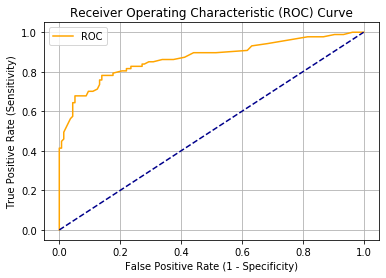

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define a function for plotting the ROC curve
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operator Characteristic (ROC) Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_roc_curve(curve_fpr, curve_tpr)

## Calculating area of ROC

A common measurement from the ROC curve is to measure the area under the curve. A model that performs no better than guessing by random chance will have an area of 0.5. A perfect model will have an area of 1.0.

sklearn has a method for calculating the ROC area-under-curve, that we will use.

In [13]:
from sklearn.metrics import auc
roc_auc = auc(curve_fpr, curve_tpr)
print ('ROC AUC: {0:0.3}'.format(roc_auc))

ROC AUC: 0.87


## Choosing threshold

Once we have decided what balance of false positive and false negative rate we want, we can look up what probability threshold to apply in order to achieve that balance. for example, if we have decided we will accept a 0.2 false positive rate, we can plot the relationship between threshold and false positive rate and read off the required threshold.

We will transfer our data to a pandas DataFrame, and then use a mask to filter data so we only see false positive rates around 0.2.

In [15]:
# Set up empty DataFrame
ROC_df = pd.DataFrame()

# Add data to DataFrame
ROC_df['threshold'] = thresholds
ROC_df['fpr'] = curve_fpr
ROC_df['tpr'] = curve_tpr

# Filter data to show false positive rates around 0.2.
mask = (ROC_df['fpr'] > 0.17) & (ROC_df['fpr'] < 0.23)
ROC_df[mask]

,threshold,fpr,tpr
34,0.34,0.227941,0.816092
35,0.35,0.220588,0.816092
36,0.36,0.220588,0.804598
37,0.37,0.220588,0.804598
38,0.38,0.205882,0.804598
39,0.39,0.176471,0.793103
40,0.40,0.176471,0.781609


From the table above you can pick the threshold to apply to classify survivors (the default threshold in `model.predict` is 0.5, but we can now use `model.predict_proba` and classify by using the desired threshold (remembering that `model.predict_proba` outputs probabilities for non-survivors (column 0) and survivors (column 1). Our new code might look something like:

In [16]:
threshold = 0.39
survived = model.predict_proba(X_test_std)[:, 1] > threshold

# Show first 5 cases
survived[0:5]

array([False, False, False, False,  True])

## Using sklearn ROC method

The method above was a manual implementation of ROC. It is useful to learn how to do this, as the same method type can be used to explore other relationships, and can be used to explore the direct effect of changing the cut-off threshold. But we can also use the sklearn `roc_curve` method which we import from `sklearn.metrics`. This, like our method above, runs the model once to predict the survival probabilities, and constructs the curve from those.

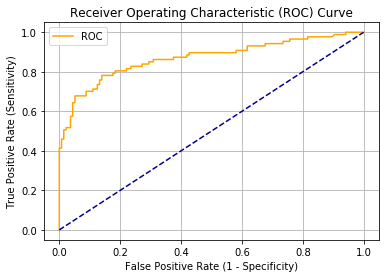

In [17]:
# Import roc_curve method
from sklearn.metrics import roc_curve

# Get probabilties from model
probabilities = model.predict_proba(X_test_std)
probabilities = probabilities[:, 1] # Probability of 'survived' class

# Get ROC curve using sklearn method
fpr, tpr, thresholds = roc_curve(y_test, probabilities) 

# Plot ROC curve
plot_roc_curve(fpr, tpr)

Note,from the above model we can see that if we pick the appropriate threshold, we can achieve a 20% false positive rate (80% specificity) and a 80% true positive rate (80% sensitivity) simultaneously.

And again we can calculate the Area Under Curve (it should be the same!)

In [18]:
roc_auc = auc(curve_fpr, curve_tpr)
print ('ROC AUC: {0:0.3}'.format(roc_auc))

ROC AUC: 0.87
